<a href="https://colab.research.google.com/github/616055/pdp_assignment_3_616055/blob/master/PDP_Assignment_3_616055.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment for Spark**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark

import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

**Load data and map the columns with Spark**

In [ ]:
# import packages
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

# start the session
findspark.init()
spark = SparkSession.builder \
            .master("local") \
            .appName("Titanic") \
            .config("spark.executor.memory", "1gb") \
            .getOrCreate()
sc = spark.sparkContext

# load the titanic text file
rdd = sc.textFile("titanic.csv")
# get the header line (first line)
header = rdd.first()
# get all rows which are not the header
rdd = rdd.filter(lambda line: line != header)
# split the values by a comma
rdd = rdd.map(lambda line: line.split(","))
# define the headers
df = rdd.map(lambda line: Row(
    survived=line[0],
    pclass=line[1],
    name=line[2],
    sex=line[3],
    age=line[4],
    siblings_spoused_aboard=line[5],
    parents_children_aboard=line[6],
    fare=line[7]
)).toDF()
# convert age values to integers
df = df.withColumn("age", df["age"].cast(IntegerType()))

**Assignment 3a**
*Calculate the conditional probability that a person survives given their sex and passenger-class*
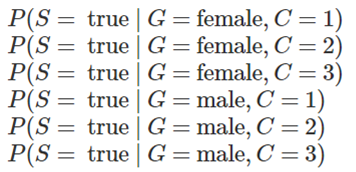

In [ ]:
def calculateProbability(df, sex, pclass):
  # where conditions for sex and passenger class
  filtered = df.rdd.filter(lambda line: line['sex'] == sex and line['pclass'] == pclass)

  # get the amount of survived and not survived persons
  survived = filtered.filter(lambda line: line['survived'] == '1').collect()
  not_survived = filtered.filter(lambda line: line['survived'] == '0').collect()

  # convert it back to a dataframe
  survived_df = spark.createDataFrame(survived)
  not_survived_df = spark.createDataFrame(not_survived)

  # get the amount of persons for survived and the total persons
  survived_persons = survived_df.count()
  total_persons = survived_persons + not_survived_df.count()

  return survived_persons, total_persons

In [ ]:
# P( S = true | G = female, C = 1 )
df1 = calculateProbability(df, 'female', '1')
print("Conditional probability of P( S = true | G = female, C = 1 ) = " + str(df1[0]) + " / " + str(df1[1]))

# P( S = true | G = female, C = 2 )
df2 = calculateProbability(df, 'female', '2')
print("Conditional probability of P( S = true | G = female, C = 2 ) = " + str(df2[0]) + " / " + str(df2[1]))

# P( S = true | G = female, C = 2 )
df3 = calculateProbability(df, 'female', '3')
print("Conditional probability of P( S = true | G = female, C = 3 ) = " + str(df3[0]) + " / " + str(df3[1]))

# P( S = true | G = male, C = 1 )
df4 = calculateProbability(df, 'male', '1')
print("Conditional probability of P( S = true | G = male, C = 1 ) = " + str(df4[0]) + " / " + str(df4[1]))

# P( S = true | G = male, C = 2 )
df5 = calculateProbability(df, 'male', '2')
print("Conditional probability of P( S = true | G = male, C = 2 ) = " + str(df5[0]) + " / " + str(df5[1]))

# P( S = true | G = male, C = 3 )
df6 = calculateProbability(df, 'male', '3')
print("Conditional probability of P( S = true | G = male, C = 3 ) = " + str(df6[0]) + " / " + str(df6[1]))

Conditional probability of P( S = true | G = female, C = 1 ) = 91 / 94<br/>
Conditional probability of P( S = true | G = female, C = 2 ) = 70 / 76<>
Conditional probability of P( S = true | G = female, C = 3 ) = 72 / 144
Conditional probability of P( S = true | G = male, C = 1 ) = 45 / 122
Conditional probability of P( S = true | G = male, C = 2 ) = 17 / 108
Conditional probability of P( S = true | G = male, C = 3 ) = 47 / 343

**Assignment 3b**
*What is the probability that a child who is in third class and is 10 years old or younger survives?*
afbeelding.png

In [ ]:
# where conditions for age and passenger class
filtered = df.rdd.filter(lambda line: line['age'] <= 10 and line['pclass'] == '3')

# get the amount of survived and not survived persons
survived = filtered.filter(lambda line: line['survived'] == '1').collect()
not_survived = filtered.filter(lambda line: line['survived'] == '0').collect()

# convert it back to a dataframe
survived_df = spark.createDataFrame(survived)
not_survived_df = spark.createDataFrame(not_survived)

# get the amount of persons for survived and the total persons
survived_persons = survived_df.count()
total_persons = survived_persons + not_survived_df.count()

percentage = survived_persons / total_persons * 100

In [ ]:
# P( S = true | A ≤ 10, C = 3 )
print("P( S = true | A ≤ 10, C = 3 ) = " + str(survived_persons) + " / " + str(total_persons) + " = " + str(percentage) + "%")
print("Beta(⍺=" + str(total_persons + 1) + ", β=" + str(total_persons + 1) + ")")

P( S = true | A ≤ 10, C = 3 ) = 22 / 53 = 41.509433962264154%<br/>
Beta(⍺=54, β=54)

**Assignment 3c**
*How much did people pay to be on the ship?*

In [ ]:
def calculateExpectation(df, pclass):
  # where condition for passenger class
  filtered = df.rdd.filter(lambda line: line['pclass'] == pclass)
  # convert it back to a dataframe
  filtered_df = spark.createDataFrame(filtered)
  # calculate the average of the paid fare
  expectation = filtered_df.groupBy('pclass').avg().collect()

  return expectation

In [ ]:
# E[ X | C = 1 ]
expectation1 = calculateExpectation(df, '1')
print("E[ X | C = 1 ] = " + str(expectation1[0][1]) + "%");

# E[ X | C = 2 ]
expectation2 = calculateExpectation(df, '2')
print("E[ X | C = 2 ] = " + str(expectation2[0][1]) + "%");

# E[ X | C = 3 ]
expectation3 = calculateExpectation(df, '3')
print("E[ X | C = 3 ] = " + str(expectation3[0][1]) + "%");

E[ X | C = 1 ] = 38.782407407407405%<br/>
E[ X | C = 2 ] = 29.847826086956523%<br/>
E[ X | C = 3 ] = 25.170431211498972%